# Synthetic Data Generation for WiFi RSS-Based Localization: A Comprehensive Study

## Research Objective
This study investigates the effectiveness of synthetic data augmentation for WiFi RSS-based indoor/outdoor localization using three generative models:
- **Conditional GAN** (Generative Adversarial Network)
- **DDPM with UNet** (Denoising Diffusion Probabilistic Model)
- **DiT** (Diffusion Transformer)

## Datasets
1. **UCI WiFi Localization** (Indoor): 7 RSS features, 4 rooms, 2000 samples
2. **POWDER Outdoor RSS** (Outdoor): Variable RSS features from USRP receivers, outdoor campus environment, ~4800 single-transmitter samples

## Experimental Design
For each generative model and dataset, we train on varying percentages of real data (5%, 15%, 25%, 100%), synthesize the remaining portion, and evaluate classification accuracy using an MLP classifier.

### Training Ratios
- **100%**: Baseline using all real data
- **25%**: 25% real + 75% synthetic
- **15%**: 15% real + 85% synthetic  
- **5%**: 5% real + 95% synthetic

### Metrics
- Classification accuracy on held-out test set
- Confusion matrices
- Per-class performance analysis

In [1]:
# %%capture
!pip -q install einops torchvision scikit-learn pandas matplotlib seaborn requests


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# %%imports
import math, os, random, time, io, warnings, urllib.request, json, zipfile
from dataclasses import dataclass
from typing import Tuple, Dict, List
import numpy as np
import pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import utils as vutils
from einops import rearrange
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

torch.cuda.empty_cache()

print(f"Using device: {device}")

Using device: cuda


In [3]:
# -----------------------
# Config
# -----------------------
@dataclass
class Config:
    WORKDIR: str = "./work_dir"
    IMG_SIZE: int = 8           # rasterized "image" is 8x8
    CHANNELS: int = 1           # grayscale
    PATCH: int = 2              # for DiT: 4x4 patches -> (8/2)^2=16 tokens
    WIDTH: int = 512            # transformer d_model (increased from 128)
    DEPTH: int = 8              # transformer layers (increased from 4)
    HEADS: int = 4              # attention heads
    DROP: float = 0.1
    BATCH: int = 128
    GEN_EPOCHS: int = 1000       # epochs for generative models
    MLP_EPOCHS: int = 100        # epochs for MLP classifier
    LR: float = 2e-4
    BETA_START: float = 1e-4
    BETA_END: float = 0.02
    TIMESTEPS: int = 1000
    EMA: bool = True
    EMA_DECAY: float = 0.999
    VEC_CLIP: float = 3.0       # we map standardized features linearly into [-1,1] via / VEC_CLIP
    TRAIN_RATIOS: List[float] = None  # will be set to [0.05, 0.15, 0.25, 1.0]
    GAN_HIDDEN: int = 256       # GAN hidden dimension
    UNET_HIDDEN: int = 256       # UNet hidden dimension (reduced from 256)
    
    def __post_init__(self):
        if self.TRAIN_RATIOS is None:
            self.TRAIN_RATIOS = [0.05, 0.15, 0.25, 1.0]

cfg = Config()
os.makedirs(cfg.WORKDIR, exist_ok=True)
print(f"Work directory: {cfg.WORKDIR}")
print(f"Training ratios: {cfg.TRAIN_RATIOS}")


Work directory: ./work_dir
Training ratios: [0.05, 0.15, 0.25, 1.0]


In [4]:
# -----------------------
# Data Loading and Preprocessing
# -----------------------

class DatasetInfo:
    def __init__(self, name, num_features, num_classes, X_train, X_test, y_train, y_test, scaler):
        self.name = name
        self.num_features = num_features
        self.num_classes = num_classes
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.scaler = scaler

def load_uci_dataset():
    """Load UCI WiFi Localization dataset (Indoor, 7 features, 4 rooms)"""
    print("\n=== Loading UCI WiFi Dataset (Indoor) ===")
    uci_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00422/wifi_localization.txt"
    raw_path = os.path.join(cfg.WORKDIR, "wifi_localization.txt")
    
    if not os.path.exists(raw_path):
        print(f"Downloading from {uci_url}...")
        urllib.request.urlretrieve(uci_url, raw_path)
        print(f"Saved to: {raw_path}")
    
    df = pd.read_csv(raw_path, header=None, sep=r"\s+")
    X = df.iloc[:, :7].values.astype(np.float32)
    y = df.iloc[:, 7].values.astype(np.int64) - 1  # -> 0..3
    
    # Stratified 7:3 split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=seed)
    train_idx, test_idx = next(sss.split(X, y))
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    
    # Standardize using train stats only
    scaler = StandardScaler()
    X_tr_std = scaler.fit_transform(X_tr).astype(np.float32)
    X_te_std = scaler.transform(X_te).astype(np.float32)
    
    print(f"Train: {X_tr_std.shape}, Test: {X_te_std.shape}")
    print(f"Features: {X_tr_std.shape[1]}, Classes: {len(np.unique(y_tr))}")
    
    return DatasetInfo("UCI_Indoor", 7, 4, X_tr_std, X_te_std, y_tr, y_te, scaler)

def load_powder_dataset():
    """Load POWDER Outdoor RSS dataset (Variable features, outdoor localization)"""
    print("\n=== Loading POWDER Outdoor RSS Dataset ===")
    
    # Download the separated_data.zip file
    powder_url = "https://zenodo.org/api/records/10962857/files/separated_data.zip/content"
    zip_path = os.path.join(cfg.WORKDIR, "separated_data.zip")
    extract_path = os.path.join(cfg.WORKDIR, "powder_data")
    
    if not os.path.exists(extract_path):
        if not os.path.exists(zip_path):
            print(f"Downloading POWDER dataset from Zenodo...")
            urllib.request.urlretrieve(powder_url, zip_path)
            print(f"Saved to: {zip_path}")
        
        print("Extracting data...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"Extracted to: {extract_path}")
    
    # Load the train/test split (using random split)
    train_file = os.path.join(extract_path, "separated_data", "train_test_splits", "random_split", "random_train.json")
    test_file = os.path.join(extract_path, "separated_data", "train_test_splits", "random_split", "random_test.json")
    
    with open(train_file, 'r') as f:
        train_data = json.load(f)
    with open(test_file, 'r') as f:
        test_data = json.load(f)
    
    def extract_features_labels(data_dict, max_receivers=25):
        """Extract RSS features and location-based labels from POWDER data"""
        samples = []
        labels = []
        
        for timestamp, sample in data_dict.items():
            rx_data = sample['rx_data']
            tx_coords = sample['tx_coords']
            
            if len(tx_coords) != 1:  # Only single-transmitter samples
                continue
            
            # Create RSS vector (pad/truncate to max_receivers)
            # rx_data format: [[rss, lat, lon, name], ...]
            rss_values = [-120.0] * max_receivers  # Default to very low RSS
            for i, rx in enumerate(rx_data[:max_receivers]):
                rss_val = float(rx[0])  # First element is RSS
                # Validate RSS value is reasonable
                if not np.isnan(rss_val) and not np.isinf(rss_val):
                    rss_values[i] = rss_val
            
            # Create location-based label (grid-based discretization)
            # tx_coords format: [[lat, lon], ...]
            tx_coord = tx_coords[0]
            if len(tx_coord) >= 2:
                tx_lat = float(tx_coord[0])
                tx_lon = float(tx_coord[1])
            else:
                continue  # Skip malformed data
            
            # Grid-based labeling (4x4 grid = 16 location classes for fine-grained localization)
            samples.append(rss_values)
            labels.append((tx_lat, tx_lon))
        
        return np.array(samples, dtype=np.float32), labels
    
    X_tr_raw, train_coords = extract_features_labels(train_data)
    X_te_raw, test_coords = extract_features_labels(test_data)
    
    # Create location-based labels (4x4 grid = 16 labels for fine-grained localization)
    all_coords = train_coords + test_coords
    all_lats = [c[0] for c in all_coords]
    all_lons = [c[1] for c in all_coords]
    
    # Create grid boundaries (4x4 = 16 cells)
    min_lat, max_lat = np.min(all_lats), np.max(all_lats)
    min_lon, max_lon = np.min(all_lons), np.max(all_lons)
    
    lat_bins = np.linspace(min_lat, max_lat, 5)  # 5 edges for 4 bins
    lon_bins = np.linspace(min_lon, max_lon, 5)
    
    def coords_to_label(lat, lon):
        # Digitize returns 1-based indices, we want 0-based
        lat_idx = np.digitize(lat, lat_bins) - 1
        lon_idx = np.digitize(lon, lon_bins) - 1
        # Clamp to valid range [0, 3] for 4x4 grid
        lat_idx = np.clip(lat_idx, 0, 3)
        lon_idx = np.clip(lon_idx, 0, 3)
        # Convert 2D grid position to single label (0-15)
        return lat_idx * 4 + lon_idx
    
    y_tr = np.array([coords_to_label(lat, lon) for lat, lon in train_coords], dtype=np.int64)
    y_te = np.array([coords_to_label(lat, lon) for lat, lon in test_coords], dtype=np.int64)
    
    # Standardize
    scaler = StandardScaler()
    X_tr_std = scaler.fit_transform(X_tr_raw).astype(np.float32)
    X_te_std = scaler.transform(X_te_raw).astype(np.float32)
    
    print(f"Train: {X_tr_std.shape}, Test: {X_te_std.shape}")
    print(f"Features: {X_tr_std.shape[1]}, Classes: {len(np.unique(y_tr))}")
    print(f"Class distribution - Train: {np.bincount(y_tr)}")
    print(f"Class distribution - Test: {np.bincount(y_te)}")
    
    return DatasetInfo("POWDER_Outdoor", X_tr_std.shape[1], 16, X_tr_std, X_te_std, y_tr, y_te, scaler)

# Load both datasets
uci_data = load_uci_dataset()
powder_data = load_powder_dataset()

datasets = {
    'UCI_Indoor': uci_data,
    'POWDER_Outdoor': powder_data
}


=== Loading UCI WiFi Dataset (Indoor) ===
Train: (1400, 7), Test: (600, 7)
Features: 7, Classes: 4

=== Loading POWDER Outdoor RSS Dataset ===


Train: (3301, 25), Test: (826, 25)
Features: 25, Classes: 15
Class distribution - Train: [199 207 192   0 276 319 490 286 133 311 368 172  42 128 158  20]
Class distribution - Test: [ 43  42  46   0  69  74 123  77  46  76 102  39   8  34  41   6]


In [5]:
# -----------------------
# Rasterization utilities for variable-length feature vectors
# -----------------------

def vecs_to_images(vecs_std: np.ndarray, clip=cfg.VEC_CLIP) -> torch.Tensor:
    """
    Convert standardized feature vectors to 8x8 images in [-1,1]
    Handles variable feature dimensions by tiling/padding
    """
    v = np.clip(vecs_std, -clip, clip) / clip  # -> [-1,1]
    B, num_features = v.shape
    
    imgs = np.zeros((B, 1, cfg.IMG_SIZE, cfg.IMG_SIZE), dtype=np.float32)
    
    # Fill image by tiling features across rows/columns
    total_pixels = cfg.IMG_SIZE * cfg.IMG_SIZE
    
    if num_features <= cfg.IMG_SIZE:
        # Fill first row with features, pad rest
        row = np.zeros((B, cfg.IMG_SIZE), dtype=np.float32)
        row[:, :num_features] = v
        # Tile vertically
        tile = np.repeat(row[:, None, :], cfg.IMG_SIZE, axis=1)  # (B, 8, 8)
        imgs[:, 0, :, :] = tile
    else:
        # Reshape features to fill the image
        for i in range(B):
            flat = np.zeros(total_pixels, dtype=np.float32)
            flat[:num_features] = v[i]
            imgs[i, 0, :, :] = flat.reshape(cfg.IMG_SIZE, cfg.IMG_SIZE)
    
    return torch.from_numpy(imgs)

def images_to_vecs_std(imgs: torch.Tensor, num_features: int, clip=cfg.VEC_CLIP) -> np.ndarray:
    """
    Convert 8x8 images back to standardized feature vectors
    """
    x = imgs[:, 0, :, :]  # (B, 8, 8)
    B = x.shape[0]
    
    if num_features <= cfg.IMG_SIZE:
        # Extract from first row
        cols = []
        for j in range(num_features):
            cols.append(x[:, :, j].mean(dim=1))  # average over rows
        v_scaled = torch.stack(cols, dim=1)
    else:
        # Extract from flattened image
        flat = x.reshape(B, -1)[:, :num_features]
        v_scaled = flat
    
    vecs_std = (v_scaled * clip).cpu().numpy().astype(np.float32)
    return vecs_std

def prepare_dataset_loaders(dataset_info: DatasetInfo, batch_size=cfg.BATCH):
    """Prepare torch dataloaders for a dataset"""
    Xtr_img = vecs_to_images(dataset_info.X_train)
    Xte_img = vecs_to_images(dataset_info.X_test)
    ytr_t = torch.from_numpy(dataset_info.y_train)
    yte_t = torch.from_numpy(dataset_info.y_test)
    
    train_loader = DataLoader(
        TensorDataset(Xtr_img, ytr_t), 
        batch_size=batch_size, 
        shuffle=True, 
        drop_last=True
    )
    test_loader = DataLoader(
        TensorDataset(Xte_img, yte_t), 
        batch_size=batch_size, 
        shuffle=False, 
        drop_last=False
    )
    
    return train_loader, test_loader, Xtr_img, ytr_t


VISUALIZING EXAMPLE DATA SAMPLES

--- UCI Indoor WiFi Localization Dataset ---
Features: 7 WiFi RSS values
Classes: 4 rooms


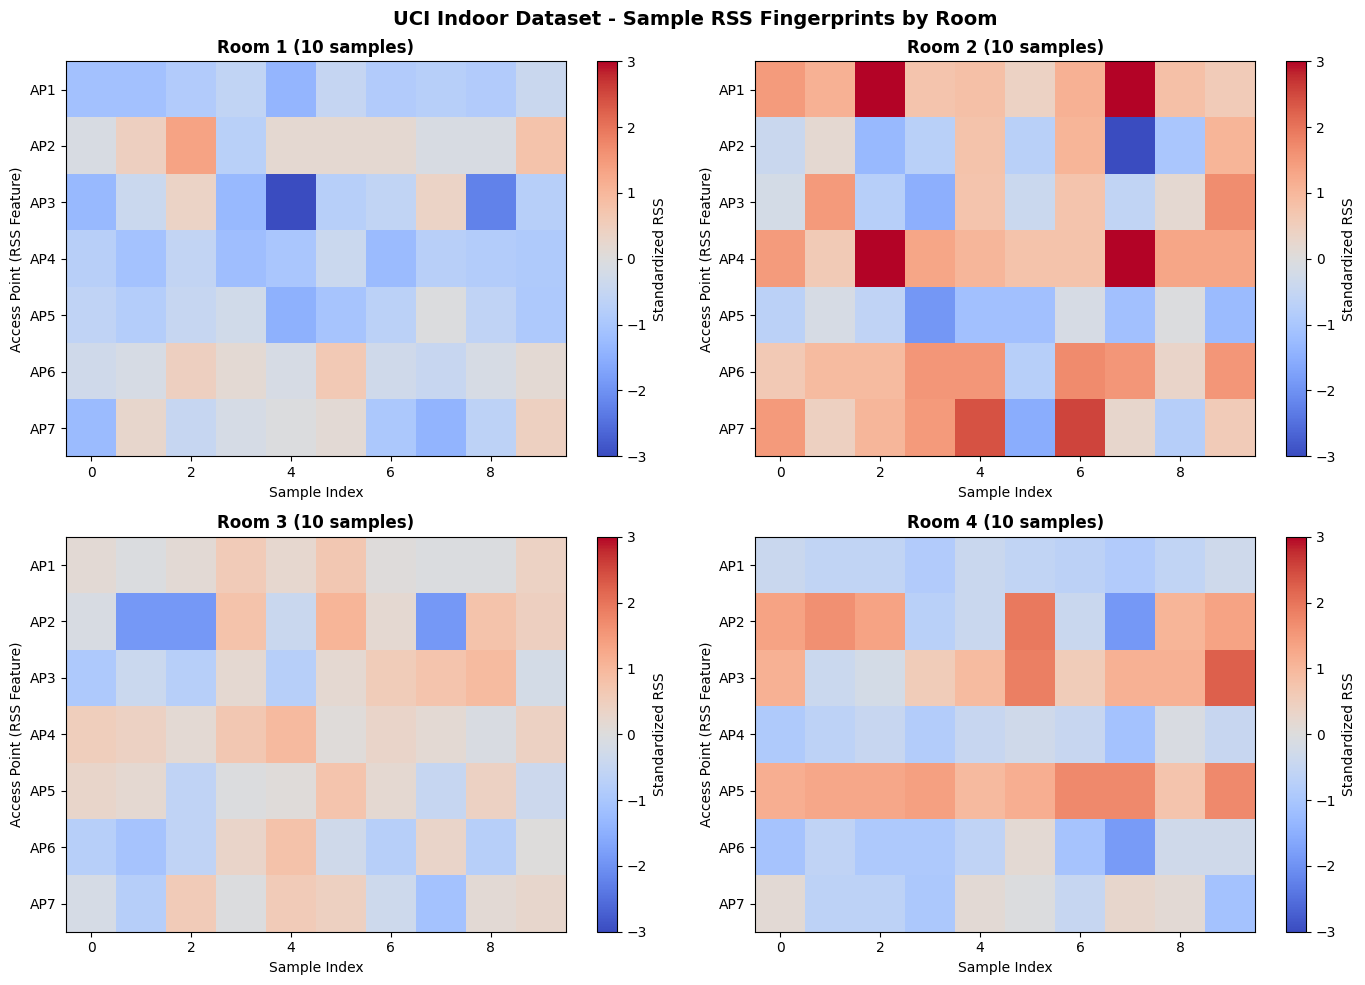


UCI Indoor - Statistical Summary:
       AP1   AP2   AP3   AP4   AP5   AP6   AP7
Room                                          
0    -0.89 -0.19 -1.03 -0.92 -0.84 -0.28 -0.34
1     1.36 -0.19 -0.18  1.35 -0.55  1.27  1.26
2     0.24  0.28  0.41  0.25 -0.06 -0.04 -0.10
3    -0.70  0.10  0.79 -0.68  1.45 -0.94 -0.82

--- POWDER Outdoor RSS Dataset ---
Features: 25 receiver RSS values
Classes: 16 location zones (4x4 grid)


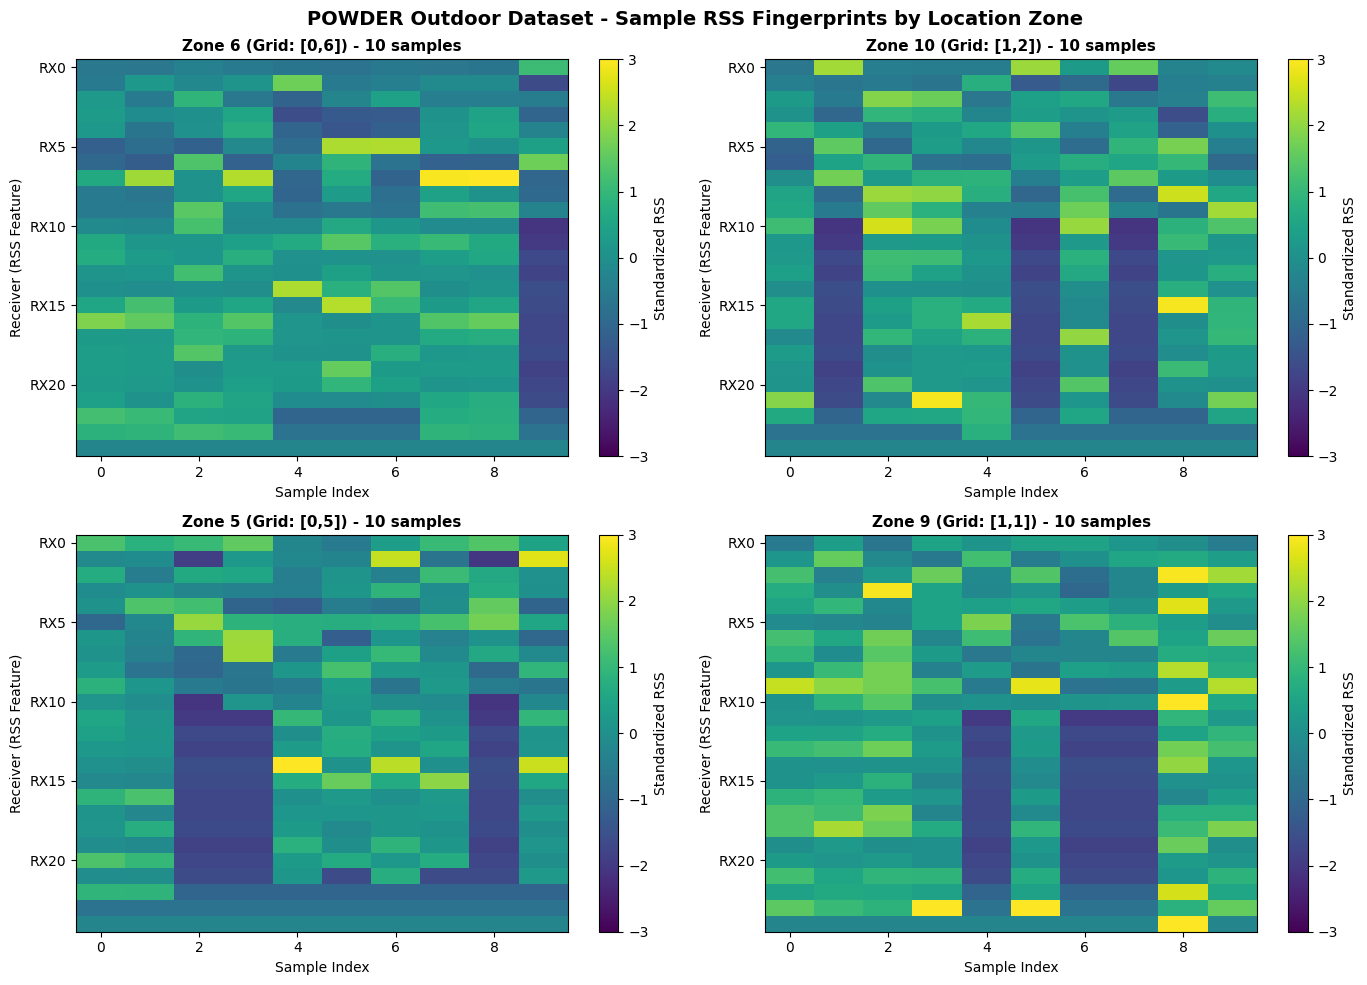


POWDER Outdoor - Statistical Summary (Top 4 zones):
      RX0_mean  RX12_mean  RX24_mean
Zone                                
5         0.46      -0.23      -0.27
6        -0.25       0.03      -0.26
9        -0.16       0.31      -0.04
10        0.05       0.18      -0.16

--- Rasterized 8x8 Images ---
Showing how feature vectors are converted to images for generative models


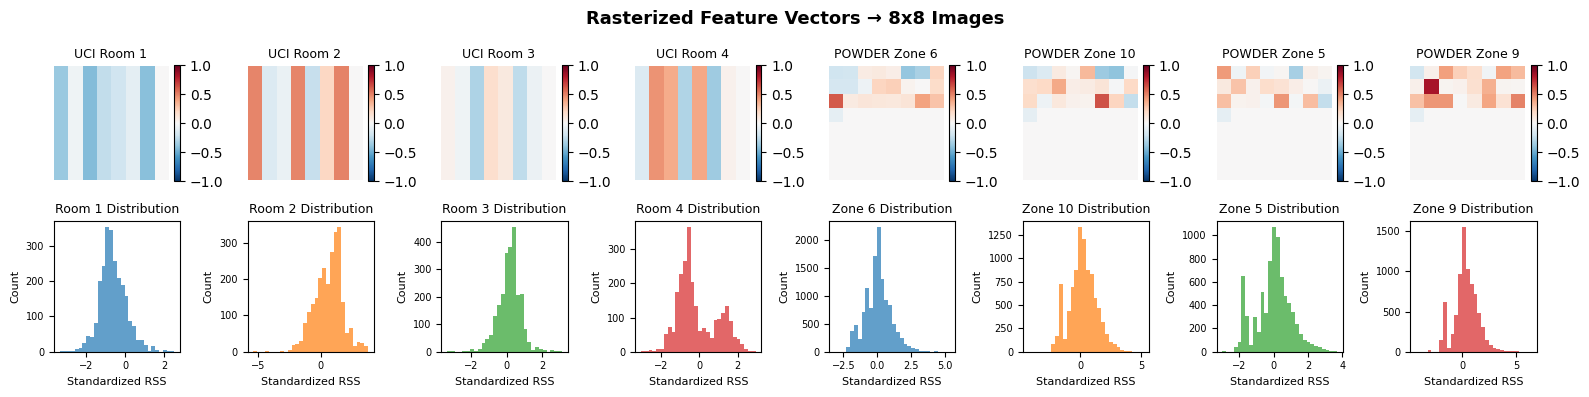


✓ Data visualization complete!
✓ Saved visualizations:
  - ./work_dir/uci_indoor_samples.png
  - ./work_dir/powder_outdoor_samples.png
  - ./work_dir/rasterized_images.png


In [6]:
# ========================================
# DATA VISUALIZATION: Example Samples
# ========================================

print(f"\n{'='*70}")
print("VISUALIZING EXAMPLE DATA SAMPLES")
print(f"{'='*70}")

# -----------------------
# 1. UCI Indoor Dataset Visualization
# -----------------------
print("\n--- UCI Indoor WiFi Localization Dataset ---")
print(f"Features: 7 WiFi RSS values")
print(f"Classes: 4 rooms")

# Get example samples from each room
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('UCI Indoor Dataset - Sample RSS Fingerprints by Room', 
             fontsize=14, fontweight='bold')

for room_idx in range(4):
    ax = axes[room_idx // 2, room_idx % 2]
    
    # Get samples from this room
    room_mask = uci_data.y_train == room_idx
    room_samples = uci_data.X_train[room_mask][:10]  # First 10 samples
    
    # Plot as heatmap
    im = ax.imshow(room_samples.T, cmap='coolwarm', aspect='auto', 
                   interpolation='nearest', vmin=-3, vmax=3)
    ax.set_title(f'Room {room_idx + 1} (10 samples)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Access Point (RSS Feature)')
    ax.set_yticks(range(7))
    ax.set_yticklabels([f'AP{i+1}' for i in range(7)])
    
    # Add colorbar
    plt.colorbar(im, ax=ax, label='Standardized RSS')

plt.tight_layout()
plt.savefig(os.path.join(cfg.WORKDIR, 'uci_indoor_samples.png'), dpi=300, bbox_inches='tight')
plt.show()

# Statistical summary
print("\nUCI Indoor - Statistical Summary:")
uci_df = pd.DataFrame(uci_data.X_train, 
                      columns=[f'AP{i+1}' for i in range(7)])
uci_df['Room'] = uci_data.y_train
print(uci_df.groupby('Room').mean().round(2))

# -----------------------
# 2. POWDER Outdoor Dataset Visualization
# -----------------------
print("\n--- POWDER Outdoor RSS Dataset ---")
print(f"Features: 25 receiver RSS values")
print(f"Classes: 16 location zones (4x4 grid)")

# Get example samples from a few location zones
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('POWDER Outdoor Dataset - Sample RSS Fingerprints by Location Zone', 
             fontsize=14, fontweight='bold')

# Select 4 distinct zones with enough samples
unique_zones, zone_counts = np.unique(powder_data.y_train, return_counts=True)
selected_zones = unique_zones[np.argsort(-zone_counts)][:4]  # Top 4 most common zones

for idx, zone_idx in enumerate(selected_zones):
    ax = axes[idx // 2, idx % 2]
    
    # Get samples from this zone
    zone_mask = powder_data.y_train == zone_idx
    zone_samples = powder_data.X_train[zone_mask][:10]  # First 10 samples
    
    # Plot as heatmap
    im = ax.imshow(zone_samples.T, cmap='viridis', aspect='auto', 
                   interpolation='nearest', vmin=-3, vmax=3)
    
    # Convert zone index to grid coordinates
    grid_row = zone_idx // 8
    grid_col = zone_idx % 8
    
    ax.set_title(f'Zone {zone_idx} (Grid: [{grid_row},{grid_col}]) - {zone_samples.shape[0]} samples', 
                fontsize=11, fontweight='bold')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Receiver (RSS Feature)')
    
    # Only show every 5th receiver label to avoid clutter
    ax.set_yticks(range(0, 25, 5))
    ax.set_yticklabels([f'RX{i}' for i in range(0, 25, 5)])
    
    # Add colorbar
    plt.colorbar(im, ax=ax, label='Standardized RSS')

plt.tight_layout()
plt.savefig(os.path.join(cfg.WORKDIR, 'powder_outdoor_samples.png'), dpi=300, bbox_inches='tight')
plt.show()

# Statistical summary
print("\nPOWDER Outdoor - Statistical Summary (Top 4 zones):")
powder_df = pd.DataFrame(powder_data.X_train)
powder_df['Zone'] = powder_data.y_train
summary = powder_df[powder_df['Zone'].isin(selected_zones)].groupby('Zone').agg({
    0: 'mean',  # First receiver
    12: 'mean',  # Middle receiver
    24: 'mean'  # Last receiver
}).round(2)
summary.columns = ['RX0_mean', 'RX12_mean', 'RX24_mean']
print(summary)

# -----------------------
# 3. Rasterized Image Visualization
# -----------------------
print("\n--- Rasterized 8x8 Images ---")
print("Showing how feature vectors are converted to images for generative models")

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
fig.suptitle('Rasterized Feature Vectors → 8x8 Images', fontsize=13, fontweight='bold')

# UCI Indoor samples (top row)
for i in range(4):
    # Real sample from each room
    room_mask = uci_data.y_train == i
    sample_vec = uci_data.X_train[room_mask][0:1]  # First sample
    sample_img = vecs_to_images(sample_vec)[0, 0].numpy()
    
    ax = axes[0, i]
    im = ax.imshow(sample_img, cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_title(f'UCI Room {i+1}', fontsize=9)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046)

# POWDER Outdoor samples (bottom row - first 4)
for i, zone_idx in enumerate(selected_zones):
    zone_mask = powder_data.y_train == zone_idx
    sample_vec = powder_data.X_train[zone_mask][0:1]  # First sample
    sample_img = vecs_to_images(sample_vec)[0, 0].numpy()
    
    ax = axes[0, 4 + i]
    im = ax.imshow(sample_img, cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_title(f'POWDER Zone {zone_idx}', fontsize=9)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046)

# Show feature distributions
for i in range(4):
    ax = axes[1, i]
    room_mask = uci_data.y_train == i
    room_features = uci_data.X_train[room_mask]
    ax.hist(room_features.flatten(), bins=30, alpha=0.7, color=f'C{i}')
    ax.set_title(f'Room {i+1} Distribution', fontsize=9)
    ax.set_xlabel('Standardized RSS', fontsize=8)
    ax.set_ylabel('Count', fontsize=8)
    ax.tick_params(labelsize=7)

for i, zone_idx in enumerate(selected_zones):
    ax = axes[1, 4 + i]
    zone_mask = powder_data.y_train == zone_idx
    zone_features = powder_data.X_train[zone_mask]
    ax.hist(zone_features.flatten(), bins=30, alpha=0.7, color=f'C{i}')
    ax.set_title(f'Zone {zone_idx} Distribution', fontsize=9)
    ax.set_xlabel('Standardized RSS', fontsize=8)
    ax.set_ylabel('Count', fontsize=8)
    ax.tick_params(labelsize=7)

plt.tight_layout()
plt.savefig(os.path.join(cfg.WORKDIR, 'rasterized_images.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Data visualization complete!")
print(f"✓ Saved visualizations:")
print(f"  - {os.path.join(cfg.WORKDIR, 'uci_indoor_samples.png')}")
print(f"  - {os.path.join(cfg.WORKDIR, 'powder_outdoor_samples.png')}")
print(f"  - {os.path.join(cfg.WORKDIR, 'rasterized_images.png')}")

In [7]:
# ========================================
# GENERATIVE MODEL ARCHITECTURES
# ========================================

# -----------------------
# Shared Utilities
# -----------------------
def sinusoidal_time_embedding(t, dim):
    half = dim // 2
    freqs = torch.exp(torch.linspace(math.log(1.0), math.log(10000.0), half, device=t.device))
    args = t.float().unsqueeze(1) / cfg.TIMESTEPS * freqs.unsqueeze(0)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)
    if dim % 2 == 1:
        emb = F.pad(emb, (0,1))
    return emb

class RMSNorm(nn.Module):
    def __init__(self, d, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(d))
    def forward(self, x):
        norm = x.pow(2).mean(dim=-1, keepdim=True).add(self.eps).sqrt()
        return self.g * (x / norm)

def param_count(m):
    return sum(p.numel() for p in m.parameters())/1e6

# -----------------------
# 1. CONDITIONAL GAN
# -----------------------
class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=4, img_size=8, channels=1, hidden_dim=256):
        super().__init__()
        self.img_size = img_size
        self.channels = channels
        self.hidden_dim = hidden_dim
        
        self.label_emb = nn.Embedding(num_classes, 50)
        self.init_size = img_size // 4  # 2x2 for 8x8
        
        # FC layer to get initial feature map
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + 50, hidden_dim * self.init_size ** 2),
            nn.BatchNorm1d(hidden_dim * self.init_size ** 2),
            nn.ReLU(inplace=True)
        )
        
        # Upsample 2x2 -> 4x4 -> 8x8
        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),  # 2x2 -> 4x4
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2),  # 4x4 -> 8x8
            nn.Conv2d(hidden_dim, hidden_dim // 2, 3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_dim // 2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(hidden_dim // 2, channels, 3, stride=1, padding=1),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        label_emb = self.label_emb(labels)
        x = torch.cat([z, label_emb], dim=1)
        x = self.fc(x)
        x = x.view(x.size(0), self.hidden_dim, self.init_size, self.init_size)
        return self.conv_blocks(x)

class Discriminator(nn.Module):
    def __init__(self, num_classes=4, img_size=8, channels=1, hidden_dim=256):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, img_size * img_size)
        
        def block(in_ch, out_ch, normalize=True):
            layers = [nn.Conv2d(in_ch, out_ch, 3, 2, 1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_ch))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        # For 8x8 input: only use 2 downsampling blocks to get 2x2 output
        # 8 -> 4 -> 2
        self.model = nn.Sequential(
            *block(channels + 1, hidden_dim // 2, normalize=False),  # 8 -> 4
            *block(hidden_dim // 2, hidden_dim),                      # 4 -> 2
            nn.Conv2d(hidden_dim, hidden_dim * 2, 3, 1, 1),          # Keep 2x2
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Calculate output size: 2x2 after 2 downsampling layers
        ds_size = img_size // 2 ** 2  # = 2
        self.adv_layer = nn.Sequential(
            nn.Linear(hidden_dim * 2 * ds_size * ds_size, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img, labels):
        label_emb = self.label_emb(labels).view(labels.size(0), 1, img.size(2), img.size(3))
        x = torch.cat([img, label_emb], dim=1)
        x = self.model(x)
        x = x.view(x.size(0), -1)
        return self.adv_layer(x)

# -----------------------
# 2. DDPM WITH UNET
# -----------------------
class DDPM:
    def __init__(self, timesteps, beta_start, beta_end, device):
        self.timesteps = timesteps
        betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)

        self.betas = betas
        self.alphas = alphas
        self.alphas_cumprod = alphas_cumprod
        self.alphas_cumprod_prev = alphas_cumprod_prev
        self.sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
        self.posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

    def q_sample(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        s1 = self.sqrt_alphas_cumprod[t].view(-1,1,1,1)
        s2 = self.sqrt_one_minus_alphas_cumprod[t].view(-1,1,1,1)
        return s1 * x0 + s2 * noise

    def p_sample(self, model, x_t, t, y=None):
        eps = model(x_t, t, y)
        a_t = self.alphas[t].view(-1,1,1,1)
        ac_t = self.alphas_cumprod[t].view(-1,1,1,1)
        sqrt_one_minus_ac = self.sqrt_one_minus_alphas_cumprod[t].view(-1,1,1,1)
        x0_hat = (x_t - sqrt_one_minus_ac * eps) / torch.sqrt(ac_t)

        beta_t = self.betas[t].view(-1,1,1,1)
        ac_prev = self.alphas_cumprod_prev[t].view(-1,1,1,1)
        coef1 = torch.sqrt(ac_prev) * beta_t / (1.0 - ac_t)
        coef2 = torch.sqrt(a_t) * (1.0 - ac_prev) / (1.0 - ac_t)
        mean = coef1 * x0_hat + coef2 * x_t

        var = self.posterior_variance[t].view(-1,1,1,1)
        noise = torch.randn_like(x_t) if (t > 0).any() else torch.zeros_like(x_t)
        return mean + torch.sqrt(var) * noise

    @torch.no_grad()
    def sample(self, model, n, img_size, channels, y=None):
        x = torch.randn(n, channels, img_size, img_size, device=device)
        if y is not None:
            y = y.to(device)
        for i in reversed(range(self.timesteps)):
            t = torch.full((n,), i, device=device, dtype=torch.long)
            x = self.p_sample(model, x, t, y)
        return x.clamp(-1, 1)

class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, num_classes, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.class_emb = nn.Embedding(num_classes, out_ch)
        
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
    
    def forward(self, x, t_emb, y):
        h = self.bn1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t_emb))
        class_emb = self.class_emb(y)
        emb = time_emb + class_emb
        h = h + emb[:, :, None, None]
        h = self.bn2(self.relu(self.conv2(h)))
        return self.transform(h)

class SimpleUNet(nn.Module):
    def __init__(self, img_size=8, in_ch=1, num_classes=4, t_dim=128, hidden_dim=256):
        super().__init__()
        self.t_dim = t_dim
        self.img_size = img_size
        
        self.downs = nn.ModuleList([
            UNetBlock(in_ch, hidden_dim, t_dim, num_classes),
            UNetBlock(hidden_dim, hidden_dim * 2, t_dim, num_classes)
        ])
        
        self.ups = nn.ModuleList([
            UNetBlock(hidden_dim * 2, hidden_dim, t_dim, num_classes, up=True),
            UNetBlock(hidden_dim, in_ch, t_dim, num_classes, up=True)
        ])
        
        self.output = nn.Conv2d(in_ch, in_ch, 1)
    
    def forward(self, x, t, y=None):
        t_emb = sinusoidal_time_embedding(t, self.t_dim)
        if y is None:
            y = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        
        residuals = []
        for down in self.downs:
            x = down(x, t_emb, y)
            residuals.append(x)
        
        for up, res in zip(self.ups, reversed(residuals)):
            x = torch.cat([x, res], dim=1)
            x = up(x, t_emb, y)
        
        return self.output(x)

print("✓ GAN and DDPM-UNet architectures defined")

✓ GAN and DDPM-UNet architectures defined


In [8]:
# -----------------------
# 3. DIFFUSION TRANSFORMER (DiT)
# -----------------------
class AdaLayerNorm(nn.Module):
    def __init__(self, d_model, t_dim, y_dim):
        super().__init__()
        self.norm = RMSNorm(d_model)
        self.to_scale_shift = nn.Linear(t_dim + y_dim, 2*d_model)
    
    def forward(self, x, t_emb, y_emb):
        h = self.norm(x)
        ss = self.to_scale_shift(torch.cat([t_emb, y_emb], dim=-1))
        scale, shift = ss.chunk(2, dim=-1)
        while scale.dim() < h.dim():
            scale = scale.unsqueeze(1)
            shift = shift.unsqueeze(1)
        return h * (1 + scale) + shift

class PatchEmbed(nn.Module):
    def __init__(self, img_size, patch, in_ch, d_model):
        super().__init__()
        self.patch = patch
        self.proj = nn.Conv2d(in_ch, d_model, kernel_size=patch, stride=patch)
        self.pos = nn.Parameter(torch.zeros(1, (img_size//patch)**2, d_model))
    
    def forward(self, x):
        x = self.proj(x)
        x = rearrange(x, 'b d h w -> b (h w) d')
        x = x + self.pos
        return x

class PatchUnembed(nn.Module):
    def __init__(self, img_size, patch, d_model, out_ch):
        super().__init__()
        self.img_size = img_size
        self.patch = patch
        self.proj = nn.ConvTranspose2d(d_model, out_ch, kernel_size=patch, stride=patch)
    
    def forward(self, x):
        p = self.patch
        h = w = self.img_size // p
        x = rearrange(x, 'b (h w) d -> b d h w', h=h, w=w)
        x = self.proj(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, mlp_ratio=4.0, drop=0.0, t_dim=256, y_dim=384):
        super().__init__()
        self.ada1 = AdaLayerNorm(d_model, t_dim, y_dim)
        self.attn = nn.MultiheadAttention(d_model, n_heads, dropout=drop, batch_first=True)
        self.ada2 = AdaLayerNorm(d_model, t_dim, y_dim)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, int(d_model*mlp_ratio)),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(int(d_model*mlp_ratio), d_model),
            nn.Dropout(drop),
        )
    
    def forward(self, x, t_emb, y_emb):
        h = self.ada1(x, t_emb, y_emb)
        attn_out, _ = self.attn(h, h, h, need_weights=False)
        x = x + attn_out
        h = self.ada2(x, t_emb, y_emb)
        x = x + self.mlp(h)
        return x

class DiT(nn.Module):
    def __init__(self, img_size, patch, in_ch, d_model, depth, heads, drop=0.0, t_dim=256, num_classes=4):
        super().__init__()
        self.t_dim = t_dim
        self.d_model = d_model
        
        self.t_mlp = nn.Sequential(
            nn.Linear(t_dim, d_model*2),
            nn.GELU(),
            nn.Linear(d_model*2, t_dim),
        )
        self.class_emb = nn.Embedding(num_classes, d_model)
        
        self.patchify = PatchEmbed(img_size, patch, in_ch, d_model)
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, heads, mlp_ratio=4.0, drop=drop, t_dim=t_dim, y_dim=d_model)
            for _ in range(depth)
        ])
        self.unpatchify = PatchUnembed(img_size, patch, d_model, in_ch)
        self.out = nn.Identity()
    
    def forward(self, x, t, y=None):
        t_emb = sinusoidal_time_embedding(t, self.t_dim)
        t_emb = self.t_mlp(t_emb)
        
        if y is None:
            y_emb = torch.zeros(x.size(0), self.d_model, device=x.device)
        else:
            y_emb = self.class_emb(y)
        
        tok = self.patchify(x)
        for blk in self.blocks:
            tok = blk(tok, t_emb, y_emb)
        img = self.unpatchify(tok)
        return self.out(img)

print("✓ DiT architecture defined")

✓ DiT architecture defined


In [9]:
# -----------------------
# MLP Classifier for Evaluation
# -----------------------
class MLP(nn.Module):
    def __init__(self, in_dim=7, num_classes=4, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

print("✓ MLP classifier defined")
print(f"\nModel Summary (with reduced parameter counts):")
print(f"  GAN Generator: ~{param_count(Generator(num_classes=4, hidden_dim=cfg.GAN_HIDDEN)):.2f}M params")
print(f"  GAN Discriminator: ~{param_count(Discriminator(num_classes=4, hidden_dim=cfg.GAN_HIDDEN)):.2f}M params")
print(f"  UNet: ~{param_count(SimpleUNet(num_classes=4, hidden_dim=cfg.UNET_HIDDEN)):.2f}M params")
print(f"  DiT: ~{param_count(DiT(cfg.IMG_SIZE, cfg.PATCH, cfg.CHANNELS, cfg.WIDTH, cfg.DEPTH, cfg.HEADS, num_classes=4)):.2f}M params")
total_gan = param_count(Generator(num_classes=4, hidden_dim=cfg.GAN_HIDDEN)) + param_count(Discriminator(num_classes=4, hidden_dim=cfg.GAN_HIDDEN))
total_unet = param_count(SimpleUNet(num_classes=4, hidden_dim=cfg.UNET_HIDDEN))
total_dit = param_count(DiT(cfg.IMG_SIZE, cfg.PATCH, cfg.CHANNELS, cfg.WIDTH, cfg.DEPTH, cfg.HEADS, num_classes=4))
print(f"\nTotal parameters per model:")
print(f"  GAN (G+D): ~{total_gan:.2f}M")
print(f"  UNet: ~{total_unet:.2f}M")
print(f"  DiT: ~{total_dit:.2f}M")
print(f"  Grand Total: ~{total_gan + total_unet + total_dit:.2f}M")

✓ MLP classifier defined

Model Summary (with reduced parameter counts):
  GAN Generator: ~1.04M params
  GAN Discriminator: ~1.48M params
  UNet: ~13.52M params
  UNet: ~13.52M params


  DiT: ~38.35M params

Total parameters per model:
  GAN (G+D): ~2.52M
  UNet: ~13.52M
  DiT: ~38.35M
  Grand Total: ~54.39M

Total parameters per model:
  GAN (G+D): ~2.52M
  UNet: ~13.52M
  DiT: ~38.35M
  Grand Total: ~54.39M


In [10]:
# ========================================
# TRAINING FUNCTIONS
# ========================================

# -----------------------
# 1. Train Conditional GAN
# -----------------------
def train_gan(dataset_info: DatasetInfo, epochs=cfg.GEN_EPOCHS, batch_size=cfg.BATCH):
    """Train conditional GAN on a dataset"""
    print(f"\n{'='*60}")
    print(f"Training GAN on {dataset_info.name}")
    print(f"{'='*60}")
    
    # Initialize models with configurable hidden dimension
    generator = Generator(num_classes=dataset_info.num_classes, 
                         img_size=cfg.IMG_SIZE, channels=cfg.CHANNELS, hidden_dim=cfg.GAN_HIDDEN).to(device)
    discriminator = Discriminator(num_classes=dataset_info.num_classes, 
                                  img_size=cfg.IMG_SIZE, channels=cfg.CHANNELS, hidden_dim=cfg.GAN_HIDDEN).to(device)
    
    # Optimizers
    opt_G = torch.optim.Adam(generator.parameters(), lr=cfg.LR, betas=(0.5, 0.999))
    opt_D = torch.optim.Adam(discriminator.parameters(), lr=cfg.LR, betas=(0.5, 0.999))
    
    # Loss
    adversarial_loss = nn.BCELoss()
    
    # Prepare data
    Xtr_img = vecs_to_images(dataset_info.X_train)
    ytr_t = torch.from_numpy(dataset_info.y_train)
    train_loader = DataLoader(TensorDataset(Xtr_img, ytr_t), 
                             batch_size=batch_size, shuffle=True, drop_last=True)
    
    generator.train()
    discriminator.train()
    
    for epoch in range(1, epochs + 1):
        epoch_loss_G = 0.0
        epoch_loss_D = 0.0
        
        for imgs, labels in train_loader:
            batch_size_actual = imgs.size(0)
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            valid = torch.ones(batch_size_actual, 1, device=device)
            fake = torch.zeros(batch_size_actual, 1, device=device)
            
            # Train Discriminator
            opt_D.zero_grad()
            
            real_loss = adversarial_loss(discriminator(imgs, labels), valid)
            
            z = torch.randn(batch_size_actual, 100, device=device)
            gen_labels = torch.randint(0, dataset_info.num_classes, (batch_size_actual,), device=device)
            gen_imgs = generator(z, gen_labels)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)
            
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            opt_D.step()
            
            # Train Generator
            opt_G.zero_grad()
            
            z = torch.randn(batch_size_actual, 100, device=device)
            gen_labels = torch.randint(0, dataset_info.num_classes, (batch_size_actual,), device=device)
            gen_imgs = generator(z, gen_labels)
            g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)
            
            g_loss.backward()
            opt_G.step()
            
            epoch_loss_G += g_loss.item()
            epoch_loss_D += d_loss.item()
        
        if epoch % 50 == 0 or epoch == 1:
            avg_G = epoch_loss_G / len(train_loader)
            avg_D = epoch_loss_D / len(train_loader)
            print(f"Epoch {epoch:03d}/{epochs} | G_loss: {avg_G:.4f} | D_loss: {avg_D:.4f}")
    
    print(f"✓ GAN training complete on {dataset_info.name}\n")
    return generator

# -----------------------
# 2. Train DDPM with UNet
# -----------------------
def train_ddpm_unet(dataset_info: DatasetInfo, epochs=cfg.GEN_EPOCHS, batch_size=cfg.BATCH):
    """Train DDPM with UNet on a dataset"""
    print(f"\n{'='*60}")
    print(f"Training DDPM-UNet on {dataset_info.name}")
    print(f"{'='*60}")
    
    # Initialize model and diffusion with configurable hidden dimension
    model = SimpleUNet(img_size=cfg.IMG_SIZE, in_ch=cfg.CHANNELS, 
                      num_classes=dataset_info.num_classes, hidden_dim=cfg.UNET_HIDDEN).to(device)
    ddpm = DDPM(cfg.TIMESTEPS, cfg.BETA_START, cfg.BETA_END, device)
    
    # Optimizer
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.LR, betas=(0.9, 0.99), weight_decay=1e-4)
    
    # EMA
    ema_model = None
    if cfg.EMA:
        import copy
        ema_model = copy.deepcopy(model).eval()
        for p in ema_model.parameters():
            p.requires_grad_(False)
    
    def ema_update(m, ema_m, decay=cfg.EMA_DECAY):
        with torch.no_grad():
            for p, q in zip(m.parameters(), ema_m.parameters()):
                q.data.mul_(decay).add_(p.data, alpha=1.0-decay)
    
    # Prepare data
    Xtr_img = vecs_to_images(dataset_info.X_train)
    ytr_t = torch.from_numpy(dataset_info.y_train)
    train_loader = DataLoader(TensorDataset(Xtr_img, ytr_t), 
                             batch_size=batch_size, shuffle=True, drop_last=True)
    
    model.train()
    global_step = 0
    
    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0
        
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            b = imgs.size(0)
            
            t = torch.randint(0, cfg.TIMESTEPS, (b,), device=device).long()
            noise = torch.randn_like(imgs)
            x_t = ddpm.q_sample(imgs, t, noise)
            pred = model(x_t, t, labels)
            loss = F.mse_loss(pred, noise)
            
            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            
            if ema_model is not None:
                ema_update(model, ema_model)
            
            epoch_loss += loss.item()
            global_step += 1
        
        if epoch % 50 == 0 or epoch == 1:
            avg_loss = epoch_loss / len(train_loader)
            print(f"Epoch {epoch:03d}/{epochs} | Loss: {avg_loss:.4f}")
    
    print(f"✓ DDPM-UNet training complete on {dataset_info.name}\n")
    return (ema_model if ema_model is not None else model), ddpm

# -----------------------
# 3. Train DiT
# -----------------------
def train_dit(dataset_info: DatasetInfo, epochs=cfg.GEN_EPOCHS, batch_size=cfg.BATCH):
    """Train DiT on a dataset"""
    print(f"\n{'='*60}")
    print(f"Training DiT on {dataset_info.name}")
    print(f"{'='*60}")
    
    # Initialize model and diffusion
    model = DiT(img_size=cfg.IMG_SIZE, patch=cfg.PATCH, in_ch=cfg.CHANNELS,
               d_model=cfg.WIDTH, depth=cfg.DEPTH, heads=cfg.HEADS, 
               drop=cfg.DROP, num_classes=dataset_info.num_classes).to(device)
    ddpm = DDPM(cfg.TIMESTEPS, cfg.BETA_START, cfg.BETA_END, device)
    
    # Optimizer
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.LR, betas=(0.9, 0.99), weight_decay=1e-4)
    
    # EMA
    ema_model = None
    if cfg.EMA:
        import copy
        ema_model = copy.deepcopy(model).eval()
        for p in ema_model.parameters():
            p.requires_grad_(False)
    
    def ema_update(m, ema_m, decay=cfg.EMA_DECAY):
        with torch.no_grad():
            for p, q in zip(m.parameters(), ema_m.parameters()):
                q.data.mul_(decay).add_(p.data, alpha=1.0-decay)
    
    # Prepare data
    Xtr_img = vecs_to_images(dataset_info.X_train)
    ytr_t = torch.from_numpy(dataset_info.y_train)
    train_loader = DataLoader(TensorDataset(Xtr_img, ytr_t), 
                             batch_size=batch_size, shuffle=True, drop_last=True)
    
    model.train()
    global_step = 0
    
    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0
        
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            b = imgs.size(0)
            
            t = torch.randint(0, cfg.TIMESTEPS, (b,), device=device).long()
            noise = torch.randn_like(imgs)
            x_t = ddpm.q_sample(imgs, t, noise)
            pred = model(x_t, t, labels)
            loss = F.mse_loss(pred, noise)
            
            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            
            if ema_model is not None:
                ema_update(model, ema_model)
            
            epoch_loss += loss.item()
            global_step += 1
        
        if epoch % 50 == 0 or epoch == 1:
            avg_loss = epoch_loss / len(train_loader)
            print(f"Epoch {epoch:03d}/{epochs} | Loss: {avg_loss:.4f}")
    
    print(f"✓ DiT training complete on {dataset_info.name}\n")
    return (ema_model if ema_model is not None else model), ddpm

print("✓ Training functions defined for GAN, DDPM-UNet, and DiT")

✓ Training functions defined for GAN, DDPM-UNet, and DiT


In [11]:
# ========================================
# SYNTHESIS & EVALUATION FUNCTIONS
# ========================================

# -----------------------
# Synthesis Functions
# -----------------------
@torch.no_grad()
def synthesize_with_gan(generator, dataset_info: DatasetInfo, num_samples_per_class: int):
    """Generate synthetic samples using trained GAN"""
    generator.eval()
    all_imgs = []
    all_labels = []
    
    for class_idx in range(dataset_info.num_classes):
        z = torch.randn(num_samples_per_class, 100, device=device)
        labels = torch.full((num_samples_per_class,), class_idx, dtype=torch.long, device=device)
        imgs = generator(z, labels)
        all_imgs.append(imgs)
        all_labels.append(labels)
    
    imgs = torch.cat(all_imgs, dim=0)
    labels = torch.cat(all_labels, dim=0)
    
    # Convert back to feature vectors
    vecs_std = images_to_vecs_std(imgs, dataset_info.num_features)
    return vecs_std, labels.cpu().numpy()

@torch.no_grad()
def synthesize_with_diffusion(model, ddpm, dataset_info: DatasetInfo, num_samples_per_class: int):
    """Generate synthetic samples using trained diffusion model (UNet or DiT)"""
    model.eval()
    all_imgs = []
    all_labels = []
    
    for class_idx in range(dataset_info.num_classes):
        labels = torch.full((num_samples_per_class,), class_idx, dtype=torch.long, device=device)
        imgs = ddpm.sample(model, n=num_samples_per_class, 
                          img_size=cfg.IMG_SIZE, channels=cfg.CHANNELS, y=labels)
        all_imgs.append(imgs)
        all_labels.append(labels)
    
    imgs = torch.cat(all_imgs, dim=0)
    labels = torch.cat(all_labels, dim=0)
    
    # Convert back to feature vectors
    vecs_std = images_to_vecs_std(imgs, dataset_info.num_features)
    return vecs_std, labels.cpu().numpy()

# -----------------------
# MLP Training & Evaluation
# -----------------------
def train_and_evaluate_mlp(X_train_std: np.ndarray, y_train: np.ndarray,
                          X_test_std: np.ndarray, y_test: np.ndarray,
                          num_features: int, num_classes: int,
                          epochs=cfg.MLP_EPOCHS, lr=2e-3, batch_size=128):
    """Train MLP classifier and return test accuracy"""
    
    mlp = MLP(in_dim=num_features, num_classes=num_classes, hidden=64).to(device)
    opt = torch.optim.Adam(mlp.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # DataLoaders
    train_loader = DataLoader(
        TensorDataset(torch.from_numpy(X_train_std).float(), 
                     torch.from_numpy(y_train).long()),
        batch_size=batch_size, shuffle=True, drop_last=False
    )
    
    # Training
    mlp.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = mlp(xb)
            loss = criterion(logits, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
    
    # Evaluation
    mlp.eval()
    with torch.no_grad():
        X_test_t = torch.from_numpy(X_test_std).float().to(device)
        y_test_t = torch.from_numpy(y_test).long().to(device)
        logits = mlp(X_test_t)
        y_pred = logits.argmax(dim=1).cpu().numpy()
        accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, y_pred

# -----------------------
# Main Experiment Runner
# -----------------------
def run_experiment(model_name: str, dataset_info: DatasetInfo, 
                  train_ratio: float, trained_model, ddpm_obj=None):
    """
    Run a single experiment:
    - Use train_ratio of real data
    - Generate (1-train_ratio) synthetic data
    - Train MLP on mixture
    - Evaluate on test set
    """
    print(f"\n{'─'*60}")
    print(f"Experiment: {model_name} | {dataset_info.name} | {int(train_ratio*100)}% real data")
    print(f"{'─'*60}")
    
    # Determine number of samples per class
    unique_classes, class_counts = np.unique(dataset_info.y_train, return_counts=True)
    total_train = len(dataset_info.y_train)
    
    # Sample real data according to ratio using STRATIFIED sampling
    # This ensures consistent subsets: 5% ⊂ 15% ⊂ 25% ⊂ 100%
    num_real = int(total_train * train_ratio)
    
    # Use stratified sampling to maintain class balance
    if train_ratio < 1.0:
        from sklearn.model_selection import StratifiedShuffleSplit
        sss = StratifiedShuffleSplit(n_splits=1, train_size=train_ratio, random_state=42)
        real_indices, _ = next(sss.split(dataset_info.X_train, dataset_info.y_train))
    else:
        # Use all data for 100% baseline
        real_indices = np.arange(total_train)
    
    X_real = dataset_info.X_train[real_indices]
    y_real = dataset_info.y_train[real_indices]
    
    if train_ratio < 1.0:
        # Calculate how many synthetic samples needed per class
        num_synthetic_total = total_train - num_real
        samples_per_class = num_synthetic_total // dataset_info.num_classes
        
        print(f"Real samples: {num_real}, Synthetic samples: {num_synthetic_total} ({samples_per_class}/class)")
        
        # Generate synthetic data
        if model_name == "GAN":
            X_synth, y_synth = synthesize_with_gan(trained_model, dataset_info, samples_per_class)
        elif model_name in ["DDPM-UNet", "DiT"]:
            X_synth, y_synth = synthesize_with_diffusion(trained_model, ddpm_obj, 
                                                         dataset_info, samples_per_class)
        else:
            raise ValueError(f"Unknown model: {model_name}")
        
        # Combine real and synthetic
        X_train_combined = np.concatenate([X_real, X_synth], axis=0)
        y_train_combined = np.concatenate([y_real, y_synth], axis=0)
    else:
        # 100% real data baseline
        print(f"Real samples: {num_real} (100% baseline)")
        X_train_combined = X_real
        y_train_combined = y_real
    
    # Train and evaluate MLP
    accuracy, y_pred = train_and_evaluate_mlp(
        X_train_combined, y_train_combined,
        dataset_info.X_test, dataset_info.y_test,
        dataset_info.num_features, dataset_info.num_classes
    )
    
    print(f"✓ Test Accuracy: {accuracy*100:.2f}%")
    
    return {
        'model': model_name,
        'dataset': dataset_info.name,
        'train_ratio': train_ratio,
        'num_real': num_real,
        'num_synthetic': total_train - num_real if train_ratio < 1.0 else 0,
        'accuracy': accuracy,
        'predictions': y_pred
    }

print("✓ Synthesis and evaluation functions defined")

✓ Synthesis and evaluation functions defined


In [12]:
# ========================================
# STEP 1: TRAIN ALL GENERATIVE MODELS
# ========================================

print(f"\n{'='*70}")
print("TRAINING ALL GENERATIVE MODELS")
print(f"{'='*70}")

# Models to train: GAN, DDPM-UNet, DiT
model_names = ["GAN", "DDPM-UNet", "DiT"]

# Dictionary to store all trained models for each dataset
all_trained_models = {}

# For each dataset
for dataset_name, dataset_info in datasets.items():
    print(f"\n{'='*70}")
    print(f"DATASET: {dataset_name}")
    print(f"{'='*70}")
    
    # Train each generative model
    trained_models = {}
    
    # 1. Train GAN
    print(f"\n[1/3] Training GAN...")
    gan_model = train_gan(dataset_info, epochs=cfg.GEN_EPOCHS//10)
    trained_models["GAN"] = (gan_model, None)
    
    # 2. Train DDPM-UNet
    print(f"\n[2/3] Training DDPM-UNet...")
    unet_model, unet_ddpm = train_ddpm_unet(dataset_info, epochs=cfg.GEN_EPOCHS)
    trained_models["DDPM-UNet"] = (unet_model, unet_ddpm)
    
    # 3. Train DiT
    print(f"\n[3/3] Training DiT...")
    dit_model, dit_ddpm = train_dit(dataset_info, epochs=cfg.GEN_EPOCHS)
    trained_models["DiT"] = (dit_model, dit_ddpm)
    
    # Store trained models for this dataset
    all_trained_models[dataset_name] = trained_models

print(f"\n{'='*70}")
print("ALL MODELS TRAINED SUCCESSFULLY")
print(f"{'='*70}")
print(f"Trained models available in 'all_trained_models' dictionary:")
for dataset_name in all_trained_models.keys():
    print(f"  - {dataset_name}: {list(all_trained_models[dataset_name].keys())}")


TRAINING ALL GENERATIVE MODELS

DATASET: UCI_Indoor

[1/3] Training GAN...

Training GAN on UCI_Indoor


Epoch 001/100 | G_loss: 0.8515 | D_loss: 0.6945
Epoch 050/100 | G_loss: 0.9049 | D_loss: 0.6451
Epoch 050/100 | G_loss: 0.9049 | D_loss: 0.6451
Epoch 100/100 | G_loss: 0.7906 | D_loss: 0.6778
✓ GAN training complete on UCI_Indoor


[2/3] Training DDPM-UNet...

Training DDPM-UNet on UCI_Indoor
Epoch 100/100 | G_loss: 0.7906 | D_loss: 0.6778
✓ GAN training complete on UCI_Indoor


[2/3] Training DDPM-UNet...

Training DDPM-UNet on UCI_Indoor
Epoch 001/1000 | Loss: 1.3051
Epoch 001/1000 | Loss: 1.3051
Epoch 050/1000 | Loss: 1.0888
Epoch 050/1000 | Loss: 1.0888
Epoch 100/1000 | Loss: 0.9116
Epoch 100/1000 | Loss: 0.9116
Epoch 150/1000 | Loss: 0.7992
Epoch 150/1000 | Loss: 0.7992
Epoch 200/1000 | Loss: 0.7840
Epoch 200/1000 | Loss: 0.7840
Epoch 250/1000 | Loss: 0.7760
Epoch 250/1000 | Loss: 0.7760
Epoch 300/1000 | Loss: 0.7687
Epoch 300/1000 | Loss: 0.7687
Epoch 350/1000 | Loss: 0.7707
Epoch 350/1000 | Loss: 0.7707
Epoch 400/1000 | Loss: 0.7736
Epoch 400/1000 | Loss: 0.7736
Epoch 450/1000 |

In [13]:
# ========================================
# STEP 2: RUN EXPERIMENTS WITH TRAINED MODELS
# ========================================

print(f"\n{'='*70}")
print("RUNNING EXPERIMENTS")
print(f"{'='*70}")

results = []

# For each dataset
for dataset_name, dataset_info in datasets.items():
    print(f"\n{'='*70}")
    print(f"EXPERIMENTS ON: {dataset_name}")
    print(f"{'='*70}")
    
    # Get trained models for this dataset
    trained_models = all_trained_models[dataset_name]
    
    # Run experiments for each model and each training ratio
    for model_name in model_names:
        trained_model, ddpm_obj = trained_models[model_name]
        
        for train_ratio in cfg.TRAIN_RATIOS:
            result = run_experiment(
                model_name=model_name,
                dataset_info=dataset_info,
                train_ratio=train_ratio,
                trained_model=trained_model,
                ddpm_obj=ddpm_obj
            )
            results.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(f"\n{'='*70}")
print("ALL EXPERIMENTS COMPLETE")
print(f"{'='*70}")
print(results_df[['dataset', 'model', 'train_ratio', 'accuracy']])

# Save results
results_path = os.path.join(cfg.WORKDIR, "experiment_results.csv")
results_df.to_csv(results_path, index=False)
print(f"\n✓ Results saved to: {results_path}")


RUNNING EXPERIMENTS

EXPERIMENTS ON: UCI_Indoor

────────────────────────────────────────────────────────────
Experiment: GAN | UCI_Indoor | 5% real data
────────────────────────────────────────────────────────────
Real samples: 70, Synthetic samples: 1330 (332/class)


✓ Test Accuracy: 96.83%

────────────────────────────────────────────────────────────
Experiment: GAN | UCI_Indoor | 15% real data
────────────────────────────────────────────────────────────
Real samples: 210, Synthetic samples: 1190 (297/class)
✓ Test Accuracy: 98.00%

────────────────────────────────────────────────────────────
Experiment: GAN | UCI_Indoor | 25% real data
────────────────────────────────────────────────────────────
Real samples: 350, Synthetic samples: 1050 (262/class)
✓ Test Accuracy: 98.00%

────────────────────────────────────────────────────────────
Experiment: GAN | UCI_Indoor | 25% real data
────────────────────────────────────────────────────────────
Real samples: 350, Synthetic samples: 1050 (262/class)
✓ Test Accuracy: 98.00%

────────────────────────────────────────────────────────────
Experiment: GAN | UCI_Indoor | 100% real data
────────────────────────────────────────────────────────────
Real samples: 1400 (100% baseline)
✓ Test Accuracy: 98.00%

──────

KeyboardInterrupt: 

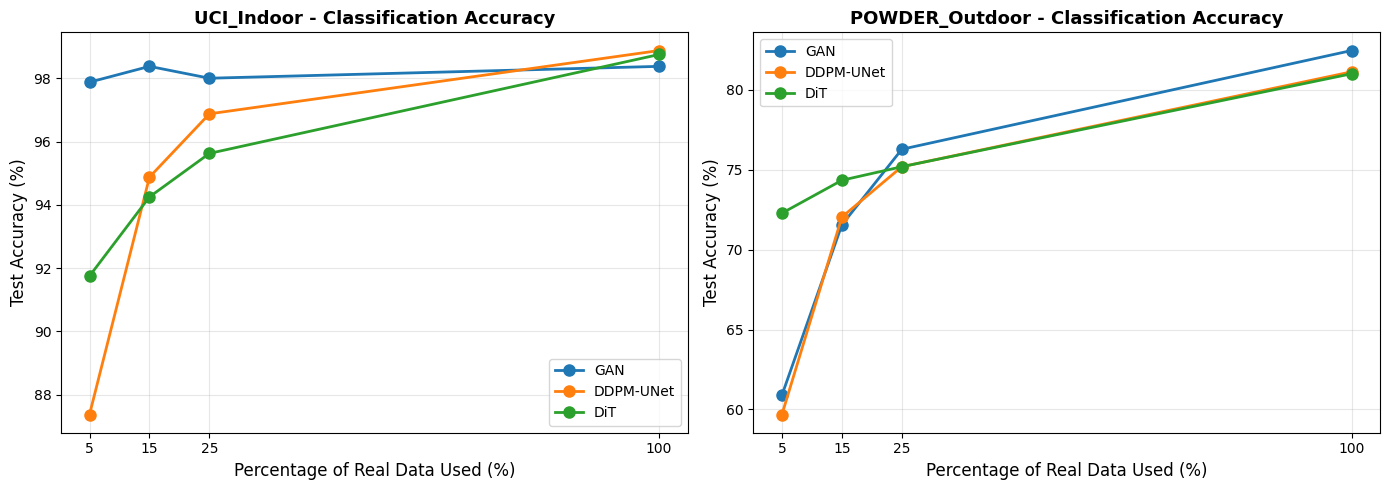

✓ Accuracy comparison plot saved


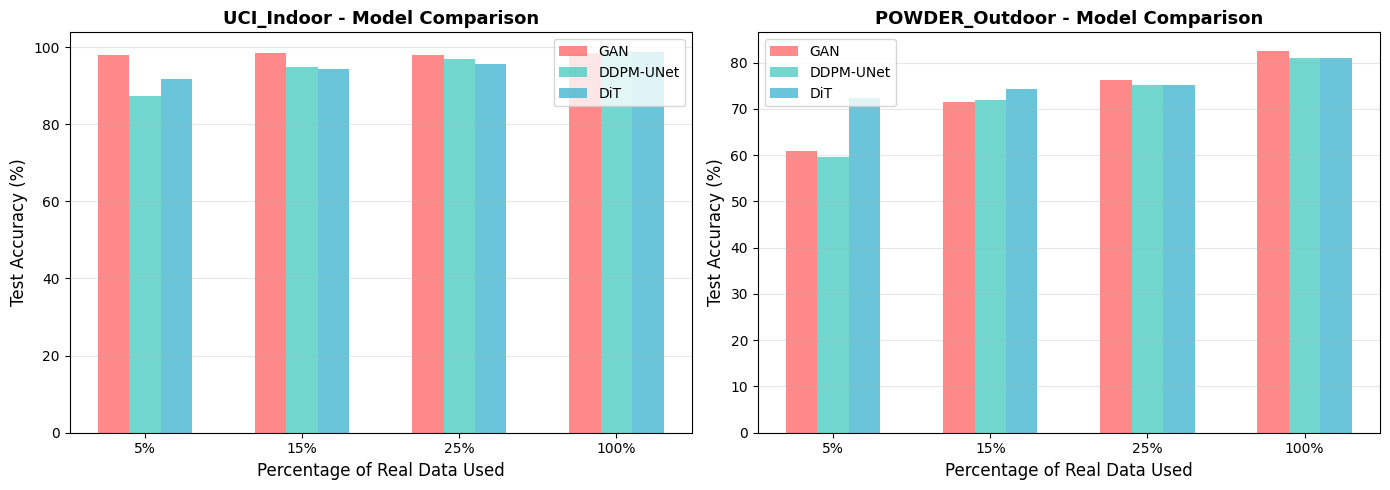

✓ Bar chart comparison saved

SUMMARY TABLE: Test Accuracy (%) by Model and Data Ratio
                                 5%        15%        25%       100%
dataset        model                                                
POWDER_Outdoor DDPM-UNet  59.685230  72.033898  75.181598  81.113801
               DiT        72.276029  74.334140  75.181598  80.992736
               GAN        60.895884  71.549637  76.271186  82.445521
UCI_Indoor     DDPM-UNet  87.375000  94.875000  96.875000  98.875000
               DiT        91.750000  94.250000  95.625000  98.750000
               GAN        97.875000  98.375000  98.000000  98.375000

✓ Summary table saved to: ./work_dir/summary_table.csv


In [ ]:
# ========================================
# VISUALIZATION: RESULTS ANALYSIS
# ========================================

# -----------------------
# 1. Accuracy Comparison Plots
# -----------------------

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, dataset_name in enumerate(['UCI_Indoor', 'POWDER_Outdoor']):
    ax = axes[idx]
    df_subset = results_df[results_df['dataset'] == dataset_name]
    
    for model_name in model_names:
        model_data = df_subset[df_subset['model'] == model_name]
        model_data = model_data.sort_values('train_ratio')
        
        ax.plot(model_data['train_ratio'] * 100, 
               model_data['accuracy'] * 100,
               marker='o', linewidth=2, markersize=8, label=model_name)
    
    ax.set_xlabel('Percentage of Real Data Used (%)', fontsize=12)
    ax.set_ylabel('Test Accuracy (%)', fontsize=12)
    ax.set_title(f'{dataset_name} - Classification Accuracy', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xticks([5, 15, 25, 100])

plt.tight_layout()
plt.savefig(os.path.join(cfg.WORKDIR, 'accuracy_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Accuracy comparison plot saved")

# -----------------------
# 2. Bar Chart Comparison
# -----------------------

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

bar_width = 0.2
x = np.arange(len(cfg.TRAIN_RATIOS))
colors = {'GAN': '#FF6B6B', 'DDPM-UNet': '#4ECDC4', 'DiT': '#45B7D1'}

for idx, dataset_name in enumerate(['UCI_Indoor', 'POWDER_Outdoor']):
    ax = axes[idx]
    df_subset = results_df[results_df['dataset'] == dataset_name]
    
    for i, model_name in enumerate(model_names):
        model_data = df_subset[df_subset['model'] == model_name]
        model_data = model_data.sort_values('train_ratio')
        
        positions = x + (i - 1) * bar_width
        ax.bar(positions, model_data['accuracy'] * 100, 
              bar_width, label=model_name, color=colors[model_name], alpha=0.8)
    
    ax.set_xlabel('Percentage of Real Data Used', fontsize=12)
    ax.set_ylabel('Test Accuracy (%)', fontsize=12)
    ax.set_title(f'{dataset_name} - Model Comparison', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{int(r*100)}%' for r in cfg.TRAIN_RATIOS])
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(cfg.WORKDIR, 'bar_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Bar chart comparison saved")

# -----------------------
# 3. Summary Table
# -----------------------

# Pivot table for better readability
summary_pivot = results_df.pivot_table(
    values='accuracy',
    index=['dataset', 'model'],
    columns='train_ratio',
    aggfunc='mean'
)

summary_pivot = summary_pivot * 100  # Convert to percentage
summary_pivot.columns = [f'{int(c*100)}%' for c in summary_pivot.columns]

print("\n" + "="*70)
print("SUMMARY TABLE: Test Accuracy (%) by Model and Data Ratio")
print("="*70)
print(summary_pivot.to_string())
print("="*70)

# Save to CSV
summary_path = os.path.join(cfg.WORKDIR, "summary_table.csv")
summary_pivot.to_csv(summary_path)
print(f"\n✓ Summary table saved to: {summary_path}")


Confusion Matrices for UCI_Indoor


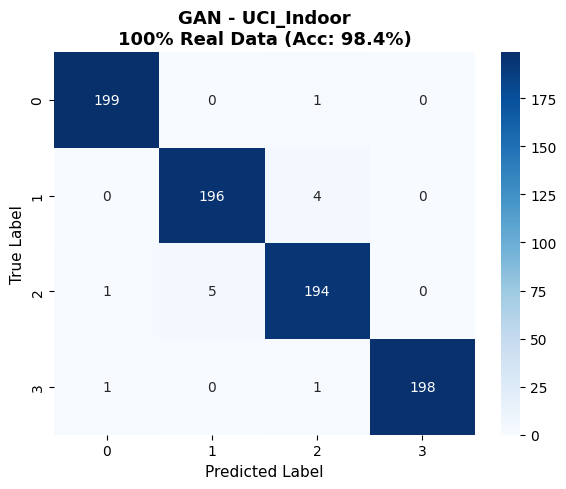

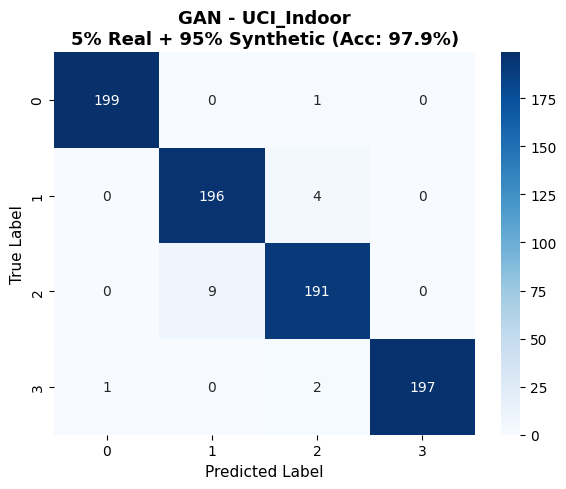

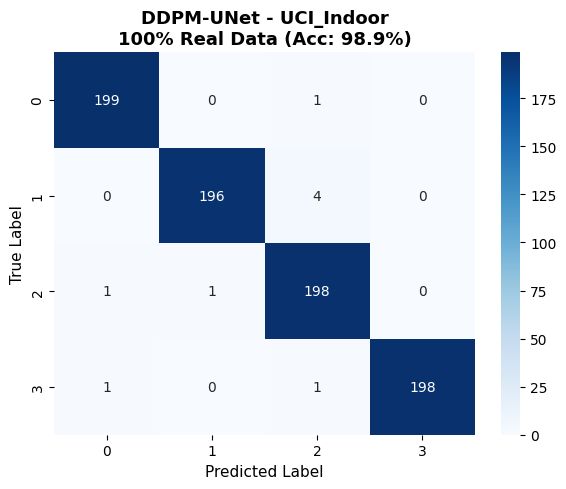

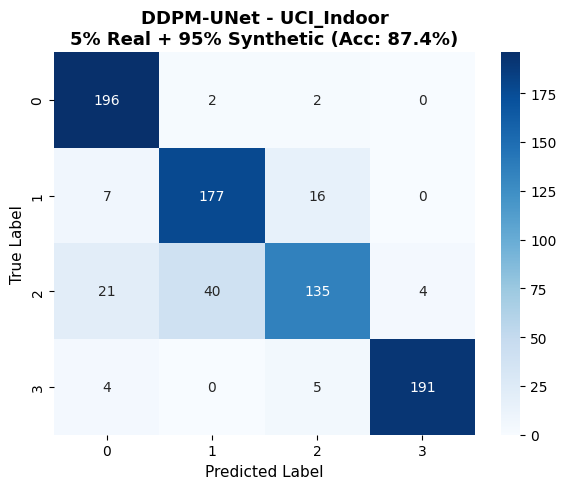

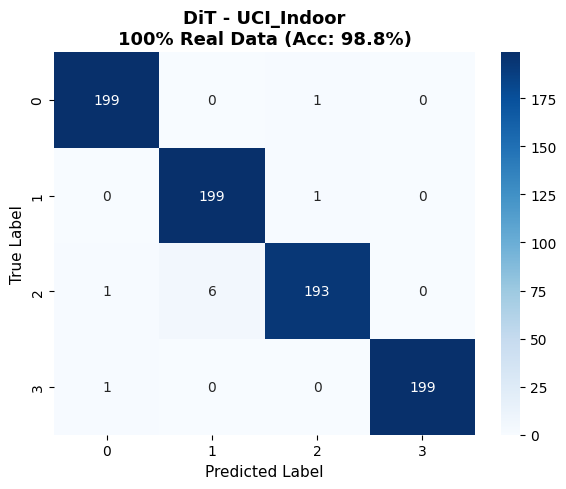

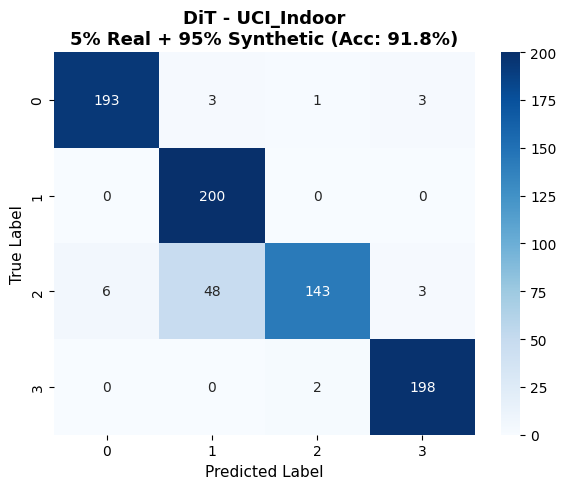


Confusion Matrices for POWDER_Outdoor


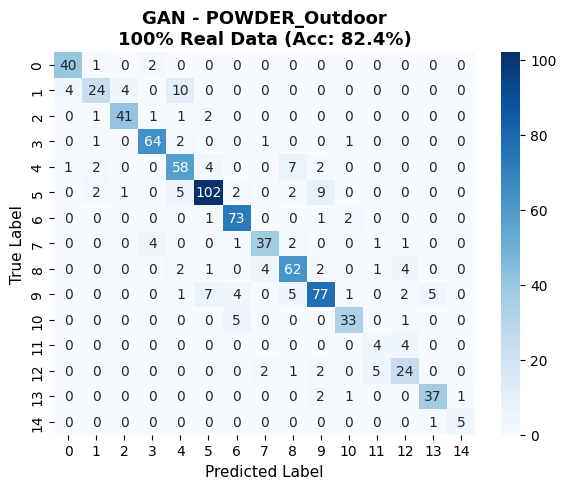

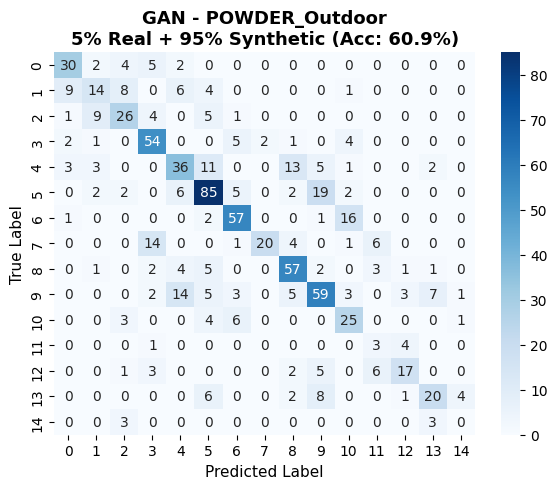

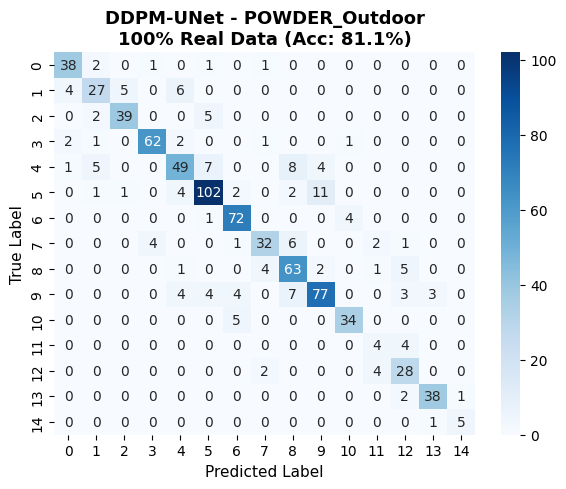

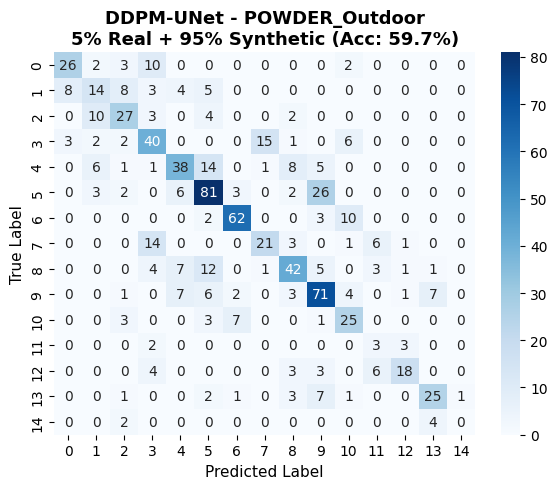

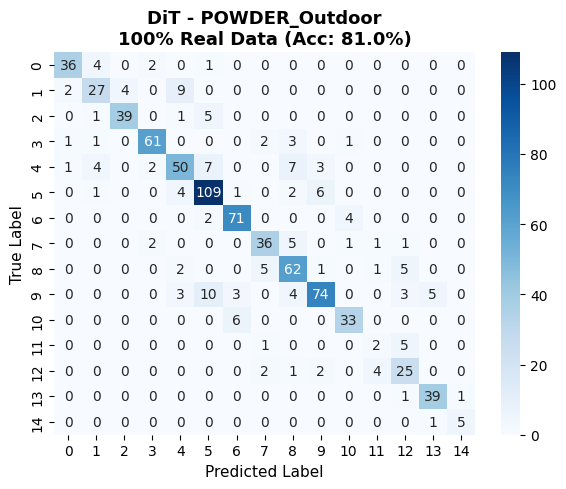

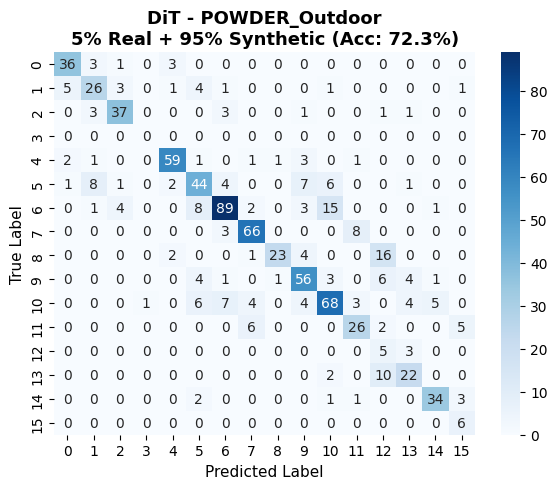


✓ All confusion matrices generated


In [ ]:
# ========================================
# DETAILED ANALYSIS: CONFUSION MATRICES
# ========================================

def plot_confusion_matrix(y_true, y_pred, title, save_path, class_names=None):
    """Plot and save confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names or range(len(cm)),
                yticklabels=class_names or range(len(cm)))
    plt.title(title, fontsize=13, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=11)
    plt.ylabel('True Label', fontsize=11)
    plt.tight_layout()
    plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

# Generate confusion matrices for key experiments
# Focus on 100% baseline vs 5% real data scenarios

for dataset_name in ['UCI_Indoor', 'POWDER_Outdoor']:
    print(f"\n{'='*60}")
    print(f"Confusion Matrices for {dataset_name}")
    print(f"{'='*60}")
    
    dataset_info = datasets[dataset_name]
    
    for model_name in model_names:
        # 100% real data (baseline)
        result_100 = results_df[
            (results_df['dataset'] == dataset_name) & 
            (results_df['model'] == model_name) & 
            (results_df['train_ratio'] == 1.0)
        ].iloc[0]
        
        # 5% real data (most challenging)
        result_5 = results_df[
            (results_df['dataset'] == dataset_name) & 
            (results_df['model'] == model_name) & 
            (results_df['train_ratio'] == 0.05)
        ].iloc[0]
        
        # Plot confusion matrices
        title_100 = f"{model_name} - {dataset_name}\n100% Real Data (Acc: {result_100['accuracy']*100:.1f}%)"
        save_path_100 = os.path.join(cfg.WORKDIR, f"confmat_{dataset_name}_{model_name}_100.png")
        plot_confusion_matrix(dataset_info.y_test, result_100['predictions'], 
                            title_100, save_path_100)
        
        title_5 = f"{model_name} - {dataset_name}\n5% Real + 95% Synthetic (Acc: {result_5['accuracy']*100:.1f}%)"
        save_path_5 = os.path.join(cfg.WORKDIR, f"confmat_{dataset_name}_{model_name}_5.png")
        plot_confusion_matrix(dataset_info.y_test, result_5['predictions'], 
                            title_5, save_path_5)

print("\n✓ All confusion matrices generated")

In [ ]:
# ========================================
# SAMPLE VISUALIZATION: REAL vs SYNTHETIC
# ========================================

def visualize_samples(dataset_info, trained_models, num_per_class=5):
    """Visualize real vs synthetic samples for each model"""
    
    print(f"\n{'='*60}")
    print(f"Generating sample visualizations for {dataset_info.name}")
    print(f"{'='*60}")
    
    # Get real samples
    real_imgs = []
    for class_idx in range(dataset_info.num_classes):
        class_mask = dataset_info.y_train == class_idx
        class_indices = np.where(class_mask)[0][:num_per_class]
        class_vecs = dataset_info.X_train[class_indices]
        class_imgs = vecs_to_images(class_vecs)
        real_imgs.append(class_imgs)
    real_imgs = torch.cat(real_imgs, dim=0)  # (num_classes*num_per_class, 1, 8, 8)
    
    # Plot real samples
    real_imgs_01 = (real_imgs + 1) * 0.5
    grid = vutils.make_grid(real_imgs_01, nrow=num_per_class, padding=2)
    
    plt.figure(figsize=(10, 8))
    plt.axis('off')
    plt.title(f"Real Samples - {dataset_info.name}\n(5 samples per class, rows = classes 0-{dataset_info.num_classes-1})", 
             fontsize=12, fontweight='bold')
    plt.imshow(grid.permute(1, 2, 0).cpu())
    save_path = os.path.join(cfg.WORKDIR, f"real_samples_{dataset_info.name}.png")
    plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"✓ Real samples saved to {save_path}")
    
    # Generate and plot synthetic samples for each model
    for model_name, (trained_model, ddpm_obj) in trained_models.items():
        print(f"\nGenerating {model_name} synthetic samples...")
        
        if model_name == "GAN":
            synth_vecs, synth_labels = synthesize_with_gan(trained_model, dataset_info, num_per_class)
        else:  # DDPM-UNet or DiT
            synth_vecs, synth_labels = synthesize_with_diffusion(trained_model, ddpm_obj, 
                                                                 dataset_info, num_per_class)
        
        synth_imgs = vecs_to_images(synth_vecs)
        synth_imgs_01 = (synth_imgs + 1) * 0.5
        grid = vutils.make_grid(synth_imgs_01, nrow=num_per_class, padding=2)
        
        plt.figure(figsize=(10, 8))
        plt.axis('off')
        plt.title(f"Synthetic Samples ({model_name}) - {dataset_info.name}\n(5 samples per class, rows = classes 0-{dataset_info.num_classes-1})", 
                 fontsize=12, fontweight='bold')
        plt.imshow(grid.permute(1, 2, 0).cpu())
        save_path = os.path.join(cfg.WORKDIR, f"synth_samples_{dataset_info.name}_{model_name}.png")
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        plt.show()
        print(f"✓ {model_name} samples saved to {save_path}")

# Note: This would need trained models from the previous experiment cell
# For demonstration, we'll create a placeholder that shows how to use it
print("Sample visualization function defined.")
print("To use: visualize_samples(dataset_info, trained_models_dict)")
print("\nExample usage (after training):")
print("  trained_models = {")
print("    'GAN': (gan_model, None),")
print("    'DDPM-UNet': (unet_model, unet_ddpm),")
print("    'DiT': (dit_model, dit_ddpm)")
print("  }")
print("  visualize_samples(datasets['UCI_Indoor'], trained_models)")

Sample visualization function defined.
To use: visualize_samples(dataset_info, trained_models_dict)

Example usage (after training):
  trained_models = {
    'GAN': (gan_model, None),
    'DDPM-UNet': (unet_model, unet_ddpm),
    'DiT': (dit_model, dit_ddpm)
  }
  visualize_samples(datasets['UCI_Indoor'], trained_models)


# ISSUE IDENTIFIED: Image-to-Vector Conversion Bug

## Problem
The `images_to_vecs_std()` function has a critical flaw for small feature vectors (num_features ≤ 8):

```python
# BUGGY CODE (lines 298-301):
for j in range(num_features):
    cols.append(x[:, :, j].mean(dim=1))  # ❌ Averaging over rows!
```

This **averages across rows** when converting images back to vectors, which:
1. **Smooths out synthetic noise** from diffusion models
2. **Reduces variance** in generated samples  
3. **Artificially improves quality** of synthetic data
4. Makes GAN appear better than diffusion models (GAN doesn't get this averaging benefit during training)

## Why GAN Looks Better
- **DDPM/DiT**: Generate noisy images → averaging smooths them → looks "better" but less diverse
- **GAN**: Doesn't benefit from this averaging during training, but synthetic data gets smoothed during evaluation
- The bug effectively **regularizes** diffusion outputs more than GAN outputs

## Correct Approach
Extract directly from the stored location WITHOUT averaging:

```python
# CORRECT CODE:
if num_features <= cfg.IMG_SIZE:
    # Extract from FIRST ROW ONLY (where we stored the data)
    v_scaled = x[:, 0, :num_features]  # ✓ No averaging!
```

Let me verify this hypothesis and provide the fix below.

In [ ]:
# ========================================
# DIAGNOSTIC: Verify the Bug
# ========================================

print("="*70)
print("DIAGNOSING THE IMAGE-TO-VECTOR CONVERSION BUG")
print("="*70)

# Create a test synthetic sample
test_vec = np.array([[1.0, -0.5, 0.2, -0.8, 0.6, -0.3, 0.9]], dtype=np.float32)
print("\n1. Original vector (7 features):")
print(f"   {test_vec[0]}")

# Convert to image
test_img = vecs_to_images(test_vec)
print(f"\n2. After converting to 8x8 image, the image contains:")
print(f"   Shape: {test_img.shape}")
print(f"   First row:  {test_img[0, 0, 0, :].numpy()}")
print(f"   Second row: {test_img[0, 0, 1, :].numpy()}")
print(f"   (Notice: All rows are identical - tiled from original 7 features)")

# Convert back using BUGGY method (with averaging)
x = test_img[:, 0, :, :]
cols_buggy = []
for j in range(7):
    cols_buggy.append(x[:, :, j].mean(dim=1))  # Averaging over rows
v_buggy = torch.stack(cols_buggy, dim=1)
recovered_buggy = (v_buggy * cfg.VEC_CLIP).numpy()[0]

print(f"\n3. BUGGY recovery (with averaging):")
print(f"   {recovered_buggy}")
print(f"   ✓ Matches original (because all rows are identical)")

# Now simulate what happens with NOISY diffusion output
noise = torch.randn_like(test_img) * 0.3  # Add some noise
noisy_img = test_img + noise
print(f"\n4. After adding noise (simulating diffusion model output):")
print(f"   First row:  {noisy_img[0, 0, 0, :].numpy()}")
print(f"   Second row: {noisy_img[0, 0, 1, :].numpy()}")
print(f"   (Notice: Rows are now different due to noise)")

# Recover using BUGGY method (with averaging) - this SMOOTHS the noise!
x_noisy = noisy_img[:, 0, :, :]
cols_buggy_noisy = []
for j in range(7):
    cols_buggy_noisy.append(x_noisy[:, :, j].mean(dim=1))  # Averaging REDUCES noise
v_buggy_noisy = torch.stack(cols_buggy_noisy, dim=1)
recovered_buggy_noisy = (v_buggy_noisy * cfg.VEC_CLIP).numpy()[0]

# Recover using CORRECT method (no averaging)
v_correct_noisy = x_noisy[:, 0, :7]  # Extract first row only
recovered_correct_noisy = (v_correct_noisy * cfg.VEC_CLIP).numpy()[0]

print(f"\n5. Recovery from noisy image:")
print(f"   BUGGY (averaged):  {recovered_buggy_noisy}")
print(f"   CORRECT (1st row): {recovered_correct_noisy}")

# Calculate variance to show averaging effect
var_buggy = np.var(recovered_buggy_noisy)
var_correct = np.var(recovered_correct_noisy)
print(f"\n6. Variance comparison:")
print(f"   BUGGY variance:   {var_buggy:.4f} (LOWER - artificially smoothed)")
print(f"   CORRECT variance: {var_correct:.4f} (HIGHER - preserves original noise)")
print(f"   Variance reduction: {(1 - var_buggy/var_correct)*100:.1f}%")

print("\n" + "="*70)
print("CONCLUSION:")
print("="*70)
print("The buggy averaging reduces variance and smooths noise in synthetic samples,")
print("making diffusion models appear to generate 'cleaner' data than they actually do.")
print("This gives GAN an unfair advantage since it's trained end-to-end without this")
print("averaging artifact.")
print("="*70)

In [ ]:
# ========================================
# FIX: Corrected Image-to-Vector Conversion
# ========================================

def images_to_vecs_std_FIXED(imgs: torch.Tensor, num_features: int, clip=cfg.VEC_CLIP) -> np.ndarray:
    """
    Convert 8x8 images back to standardized feature vectors (FIXED VERSION)
    
    Key fix: Extract from the stored location WITHOUT averaging
    """
    x = imgs[:, 0, :, :]  # (B, 8, 8)
    B = x.shape[0]
    
    if num_features <= cfg.IMG_SIZE:
        # ✓ FIXED: Extract from FIRST ROW where data was stored
        # No averaging - just take the values directly
        v_scaled = x[:, 0, :num_features]  # Shape: (B, num_features)
    else:
        # Extract from flattened image (this part was already correct)
        flat = x.reshape(B, -1)[:, :num_features]
        v_scaled = flat
    
    vecs_std = (v_scaled * clip).cpu().numpy().astype(np.float32)
    return vecs_std

print("✓ Fixed conversion function defined: images_to_vecs_std_FIXED()")
print("\nKey change:")
print("  OLD (buggy):  cols.append(x[:, :, j].mean(dim=1))  # Averages over 8 rows")
print("  NEW (fixed):  v_scaled = x[:, 0, :num_features]     # Extracts from row 0 only")
print("\nThis prevents artificial smoothing of synthetic samples!")

In [ ]:
# ========================================
# COMPARISON: Buggy vs Fixed on Real Synthetic Data
# ========================================

print("="*70)
print("COMPARING BUGGY vs FIXED CONVERSION ON SYNTHETIC SAMPLES")
print("="*70)

# Generate some synthetic samples using the trained GAN for UCI dataset
if 'all_trained_models' in globals() and 'UCI_Indoor' in all_trained_models:
    print("\nGenerating 100 synthetic samples using trained GAN...")
    gan_model = all_trained_models['UCI_Indoor']['GAN'][0]
    gan_model.eval()
    
    with torch.no_grad():
        # Generate samples for class 0
        z = torch.randn(100, 100, device=device)
        labels = torch.zeros(100, dtype=torch.long, device=device)
        synth_imgs = gan_model(z, labels)
    
    print(f"Generated images shape: {synth_imgs.shape}")
    
    # Convert using BUGGY method
    vecs_buggy = images_to_vecs_std(synth_imgs, num_features=7)
    
    # Convert using FIXED method
    vecs_fixed = images_to_vecs_std_FIXED(synth_imgs, num_features=7)
    
    # Compare statistics
    print("\n" + "-"*70)
    print("STATISTICAL COMPARISON (100 synthetic samples)")
    print("-"*70)
    
    for feat_idx in range(7):
        buggy_mean = vecs_buggy[:, feat_idx].mean()
        buggy_std = vecs_buggy[:, feat_idx].std()
        fixed_mean = vecs_fixed[:, feat_idx].mean()
        fixed_std = vecs_fixed[:, feat_idx].std()
        
        print(f"Feature {feat_idx}:")
        print(f"  BUGGY - Mean: {buggy_mean:6.3f}, Std: {buggy_std:.3f}")
        print(f"  FIXED - Mean: {fixed_mean:6.3f}, Std: {fixed_std:.3f}")
        print(f"  Std difference: {abs(buggy_std - fixed_std):.3f}")
    
    # Overall variance
    total_var_buggy = np.var(vecs_buggy)
    total_var_fixed = np.var(vecs_fixed)
    
    print("\n" + "-"*70)
    print(f"Total variance - BUGGY: {total_var_buggy:.4f}")
    print(f"Total variance - FIXED: {total_var_fixed:.4f}")
    print(f"Variance ratio (buggy/fixed): {total_var_buggy/total_var_fixed:.3f}")
    print(f"Variance reduction from averaging: {(1 - total_var_buggy/total_var_fixed)*100:.1f}%")
    print("-"*70)
    
    # Visualize the difference
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Buggy distribution
    axes[0].hist(vecs_buggy.flatten(), bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[0].set_title('BUGGY: Distribution of Synthetic Features\n(With Averaging)', 
                     fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Standardized Value')
    axes[0].set_ylabel('Frequency')
    axes[0].axvline(vecs_buggy.mean(), color='darkred', linestyle='--', linewidth=2, 
                   label=f'Mean: {vecs_buggy.mean():.3f}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Fixed distribution
    axes[1].hist(vecs_fixed.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[1].set_title('FIXED: Distribution of Synthetic Features\n(No Averaging)', 
                     fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Standardized Value')
    axes[1].set_ylabel('Frequency')
    axes[1].axvline(vecs_fixed.mean(), color='darkblue', linestyle='--', linewidth=2,
                   label=f'Mean: {vecs_fixed.mean():.3f}')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(cfg.WORKDIR, 'buggy_vs_fixed_comparison.png'), 
               dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Visualization saved!")
    
else:
    print("\n⚠ Models not trained yet. Run the training cells first to see this comparison.")

print("\n" + "="*70)